# Final Project
#### University of Vermont, CS295 Data Privacy
***
#### Authors: Dave Landay, Samson Durst                   
***
## Introduction
***
TODO:
* Define what Edge-DP is and how it is achieved
    * Two Graphs G and G' are neighbors if they differ by one edge 
* Define what Node-DP is and how it is achieved
    * Two graphs G and G' are neighbors if one can be obtained from the other by deleting a node and its adjacent edges. (i.e: differ by one node and sum total of edges connecting that node to other nodes in the network)
* Describe the issues with releasing certain graph metrics (i.e: releasing the number of edges doesn't satisfy node-DP)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import count
import seaborn as sns
import sys
sys.path.append("..")

#Import stuff from dpnet package here ...
from dpnet import load_mtx, mechanisms, tools

# Load Networks (networkx actually includes the karate club network):
#karate = load_mtx.load_mtx('../networks/karate/karate.mtx', create_using=None)
karate = nx.karate_club_graph()

#### Display an example network (Zachary's Karate club):

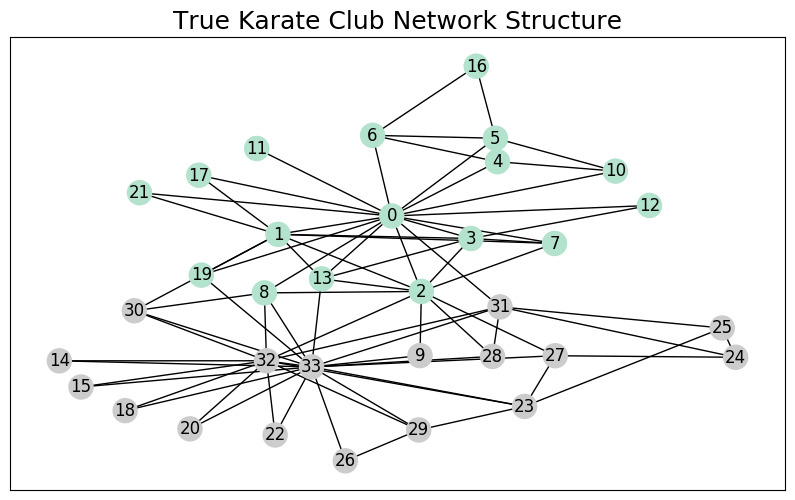

In [2]:
clubs = set(nx.get_node_attributes(karate,'club').values())
mapping = dict(zip(sorted(clubs),count()))
colors = [mapping[karate.nodes[n]['club']] for n in karate.nodes]
fig, ax = plt.subplots(figsize=(10,6), dpi=100)
pos = nx.kamada_kawai_layout(karate, scale=0.5)
ec = nx.draw_networkx_edges(karate, pos)
nc = nx.draw_networkx_nodes(karate, pos, node_color=colors, cmap=plt.cm.Pastel2)
nx.draw_networkx_labels(karate, pos)
plt.title('True Karate Club Network Structure', fontsize=18)
plt.show()

In [3]:
num_nodes = len(karate.nodes)
num_edges = len(karate.edges)
print('number of edges in the karate network: {}\n \
number of nodes in the karate network: {}'.format(num_edges, num_nodes))

number of edges in the karate network: 78
 number of nodes in the karate network: 34


#### Over graphs, simple 1-dimensional queries (like counting the number of nodes) satisfy $(\epsilon, 0)$-node-DP

In [4]:
epsilon = 0.1
sensitivity = 1
noisy_n = mechanisms.laplace_mech(num_nodes, epsilon, sensitivity)

#### But releasing the number of edges is not kosher; it does not statisfy $(\epsilon,0)$-node-DP because removing one node could remove an unbounded number of edges

#### Further more, if we look at the true degree distribution, we find that finding an upperbound on the number of edges will have an effect on privacy. If we select an upperbound $k = |V|$, where $V$ is the set of vertices (nodes) in the graph, then we achieve good privacy, but destroy the utility of the released query answer:

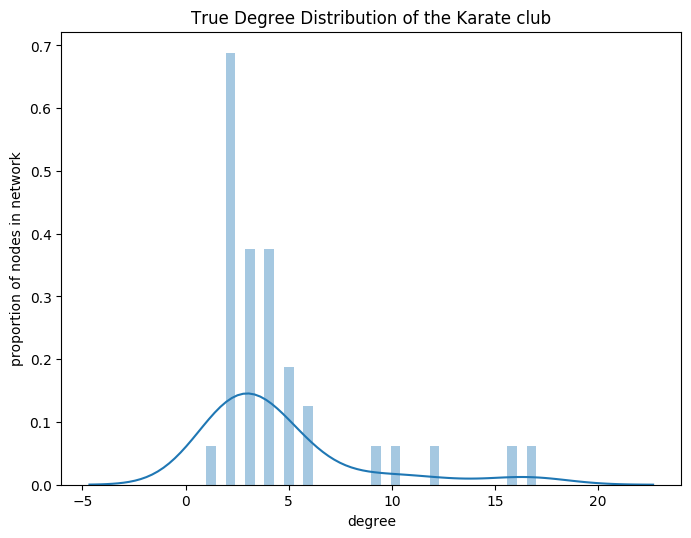

In [5]:
plt.subplots(figsize=(8,6), dpi=100)
bins = int(len(karate.nodes))
sns.distplot([v for k,v in karate.degree()], bins=bins)
plt.xlabel("degree")
plt.ylabel("proportion of nodes in network")
plt.title("True Degree Distribution of the Karate club")
plt.show()

#### Many real-world networks can exhibit power-law degree distributions, or extremely heavy tailed distributions. Hence, the sensitivity of counting queries (specifically range queries) needs to be high. So, we cannot use global sensitivity and expect to maintain privacy. For example, we can use the laplace mechanism to release the number of edges if we find an upper bound on sensitivity first! To do this, we can set an arbitrary upper bound on the number of edges and then remove edges from the graph if a node has more than the proposed bound. Then, we can use the laplace mech scaled to the sensitivity of the upper bound to release the number of edges:

In [6]:
upper = 10
g = tools.clipGraph(karate, upper)
for i in range(10):
    np.random.seed(i)
    print('Noisy edge count that satisfies node-dp: {}'.format(mechanisms.laplace_mech(len(g.edges), epsilon, upper)))

Noisy edge count that satisfies node-dp: 73.27273276031647
Noisy edge count that satisfies node-dp: 44.85308910552921
Noisy edge count that satisfies node-dp: 49.30224525236329
Noisy edge count that satisfies node-dp: 73.71352063225345
Noisy edge count that satisfies node-dp: 334.90051585381184
Noisy edge count that satisfies node-dp: -18.196147788006655
Noisy edge count that satisfies node-dp: 217.04731214107503
Noisy edge count that satisfies node-dp: -124.98265241723666
Noisy edge count that satisfies node-dp: 200.38078652266293
Noisy edge count that satisfies node-dp: -324.52905888166185


#### Several of the queries return a decent estimate of the true number of edges. But, clearly for large networks with heavy-tail degree distribution, we cannot use global sensitivity because we risk setting it too high. 

In [7]:
d = tools.create_dict(karate.nodes, karate.edges)
def clip_d(d, upper, lower):
    for x, y in d.items():
        if x > upper:
            d[upper] += y
        elif x < lower:
            d[lower] += y
    return d
        
def test_mean(d, k, upper, lower, epsilon):
    clipped = clip_d(d, upper, lower)
    result = tools.edge_mean(clipped)
    sensitivity = (upper - lower) / k
    
    dp_avg = mechanisms.laplace_mech(result, sensitivity, epsilon)
    return dp_avg

x = test_mean(d, 20, 20, 0, 1)
x

2.9155209359874794

In [8]:
y = tools.edge_mean(d)

In [9]:
k = 30
epsilon = 0.1
sensitivity = tools.smoothSensitivity(g,upper,k,epsilon)
noisy_edge_count = mechanisms.laplace_mech(len(g.edges), epsilon, sensitivity)
noisy_edge_count

62.765331625589575

In [256]:
def node_privacy(epsilon, capacity, n, G):
    e1_hat = mechanisms.laplace_mech(len(G.edges), epsilon, 2*n)
    tao = (n*np.log(n))/epsilon
    if e1_hat >= 3*tao:
        return e1_hat
    else:
        new_g = tools.clipGraph(G, capacity)
        total = 2*max(new_g.degree)
        return mechanisms.laplace_mech(total[1]/2, epsilon, 2*capacity)

In [289]:
np.mean([node_privacy(4, 20, len(karate.nodes), karate) for i in range(0,100)])

36.932840908903096